In [1]:
#%pylab inline
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
plt.style.use('ggplot') 
import datetime as dt

/projectnb/landsat/users/valpasq/conda/envs/forest/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
import yatsm
from yatsm.io import read_pixel_timeseries
from yatsm.utils import csvfile_to_dataframe, get_image_IDs
from yatsm.config_parser import convert_config, parse_config_file
from yatsm.config_parser import convert_config, parse_config_file
import yatsm._cyprep as cyprep

In [3]:
col_names = ['date', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw']
band_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw', 'fmask']

In [4]:
# Set percentiles for range calculations
pct1=0.05
pct2=0.95

In [5]:
# Set date limits for TS plots
xmin = dt.datetime.strptime('1983 1', '%Y %j')
xmax = dt.datetime.strptime('2014 365', '%Y %j')

In [6]:
# Set seasons based on months
# dictionary = name, (months), color, alpha
SEASONS = {
    'winter': ((11, 12, 1, 2, 3), 'b', 0.75),
    'spring': ((4, 5), 'c', 0.75),
    'summer': ((6, 7, 8), 'g', 0.75,),
    'fall': ((9, 10), 'y', 0.75)
}

# SETUP LEGEND 
# TODO: Make this more general! Can use dictionary above
winter = mlines.Line2D([], [], linewidth=0, color='b', marker='o',
                          markersize=4, label='Nov - Mar', alpha=0.8)
spring = mlines.Line2D([], [], linewidth=0, color='c', marker='o',
                          markersize=4, label='Apr / May', alpha=0.8)
summer = mlines.Line2D([], [], linewidth=0, color='g', marker='o',
                          markersize=4, label='Jun - Aug', alpha=0.8)
fall = mlines.Line2D([], [], linewidth=0, color='y', marker='o',
                          markersize=4, label='Sep / Oct', alpha=0.8)

In [7]:
## SPECIFY CONFIG FILE
config_file = '/projectnb/landsat/users/valpasq/LCMS/stacks/p045r030/p045r030_config_LCMS.yaml'

# Read in and parse config file
cfg = parse_config_file(config_file)

/projectnb/landsat/users/valpasq/conda/envs/forest/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
# Get files list
df = csvfile_to_dataframe(cfg['dataset']['input_file'], \
                          date_format=cfg['dataset']['date_format'])

In [21]:
# 4855 PIXEL ROW AND COLUMN
py = 4855 # row 
px = 4195 # column
name = 'Riverine' # pixel name (for plot titles)

# SPECIFY DATES for vertical lines on TS figures
#change_date = datetime.datetime.strptime('2010 050', '%Y %j')
change_date = [] # if none
#CCDC_date = datetime.datetime.strptime('2006 111', '%Y %j')
CCDC_date = [] # if none

# Get dates for image stack
df['image_ID'] = get_image_IDs(df['filename']) 
df['x'] = df['date'] 
dates = df['date'].values

# Read in time series as numpy array
Y = read_pixel_timeseries(df['filename'], px, py)

# Write unmasked TS data and dates to CSV
TS=pd.DataFrame(Y.T, columns=band_names)
TS.insert(0, value=dates, column='ordinaldate')
TS.to_csv('./example_data/{y}_{x}_{name}_TS-raw.csv'.format(x=px, y=py, name=name))

if (Y[0:6] == -9999).mean() > 0.3: # skip if TS is all nodata
    pass  # (this is really only necessary if running over entire image)

else: # process time series

    # Mask based on physical constraints and Fmask 
    valid = cyprep.get_valid_mask( \
                Y, \
                cfg['dataset']['min_values'], \
                cfg['dataset']['max_values']).astype(bool)

    # Apply mask band
    idx_mask = cfg['dataset']['mask_band'] - 1
    valid *= np.in1d(Y.take(idx_mask, axis=0), \
                             cfg['dataset']['mask_values'], \
                             invert=True).astype(np.bool)

    # Mask time series using fmask result
    Y_fmask = np.delete(Y, idx_mask, axis=0)[:, valid]
    dates_fmask = dates[valid]

    # Apply multi-temporal mask (modified tmask)
    # Step 1. mask where green > 3 stddev from mean (fmasked) green
    multitemp1_fmask = np.where(Y_fmask[1] < (np.mean(Y_fmask[1])+np.std(Y_fmask[1])*3))
    dates_fmask = dates_fmask[multitemp1_fmask[0]] 
    Y_fmask = Y_fmask[:, multitemp1_fmask[0]]
    # Step 2. mask where swir < 3 std devfrom mean (fmasked) SWIR
    multitemp2_fmask = np.where(Y_fmask[4] > (np.mean(Y_fmask[4])-np.std(Y_fmask[4])*3))
    dates_fmask = dates_fmask[multitemp2_fmask[0]] 
    Y_fmask = Y_fmask[:, multitemp2_fmask[0]]
    
    # convert SR x 10000 to float
    Y_fmask = Y_fmask.astype(float)/10000 

    # convert time from ordinal to dates
    dt_dates_fmask = np.array([dt.datetime.fromordinal(d) for d in dates_fmask])

    # Create dataframes for analysis 
    # Step 1. reshape data
    shp_ = dt_dates_fmask.shape[0]
    dt_dates_fmask_csv = dt_dates_fmask.reshape(shp_, 1)
    Y_fmask_csv = np.transpose(Y_fmask)
    data_fmask = np.concatenate([dt_dates_fmask_csv, Y_fmask_csv], axis=1)
    # Step 2. create dataframe
    data_fmask_df = pd.DataFrame(data_fmask, columns=col_names)
    # convert reflectance to numeric type
    data_fmask_df[band_names[0:10]] = data_fmask_df[band_names[0:10]].astype(float) 
    ## WRITE TO CSV ##
    data_fmask_df.to_csv('./example_data/{y}_{x}_{name}_TS.csv'.format(x=px, y=py, name=name))
    
print('Time series processing complete!')

Time series processing complete!


In [24]:
# Group observations by year to generate annual TS
year_group_fmask = data_fmask_df.groupby(data_fmask_df.date.dt.year)
# get years in time series 
years_fmask = np.asarray(year_group_fmask.groups.keys()) 
years_fmask = years_fmask.astype(int)

# Calculate number of observations
nobs = year_group_fmask['tcb'].count()

### TC Brightness
# Calculate mean annual TCB
TCB_mean = year_group_fmask['tcb'].mean()
# Calculate year-to-year difference in mean TCB
TCB_mean_diff = np.diff(TCB_mean)
# Cumulative sum of annual difference in TCB
TCB_mean_sum = np.cumsum(TCB_mean_diff)
# percentile clip 
TCB_iqr_H = year_group_fmask['tcb'].quantile([pct2])
TCB_iqr_L = year_group_fmask['tcb'].quantile([pct1])
TCB_iqr = np.asarray(TCB_iqr_H - TCB_iqr_L)

### TC Greenness 
TCG_mean = year_group_fmask['tcg'].mean()
# Find annual min TCG
TCG_min = year_group_fmask['tcg'].min()
# Find annual max TCG
TCG_max = year_group_fmask['tcg'].max()  
# Calculate annual range TCG       
TCG_amp = np.asarray(TCG_max - TCG_min)
# Normalize to first year's value (assuming forest)
#TCG_amp_adj = TCG_amp.astype(float) / TCG_amp[0].astype(float) 
# percentile clip 
TCG_iqr_H = year_group_fmask['tcg'].quantile([pct2])
TCG_iqr_L = year_group_fmask['tcg'].quantile([pct1])
TCG_iqr = np.asarray(TCG_iqr_H - TCG_iqr_L)

### TC Wetness 
# Calculate mean annual TCW
TCW_mean = year_group_fmask['tcw'].mean()
# Calculate year-to-year difference in mean TCB
TCW_mean_diff = np.diff(TCW_mean)
# Cumulative sum of annual difference in TCB
TCW_mean_sum = np.cumsum(TCW_mean_diff)
# percentile clip 
TCW_iqr_H = year_group_fmask['tcw'].quantile([pct2])
TCW_iqr_L = year_group_fmask['tcw'].quantile([pct1])
TCW_iqr = np.asarray(TCW_iqr_H - TCG_iqr_L)  

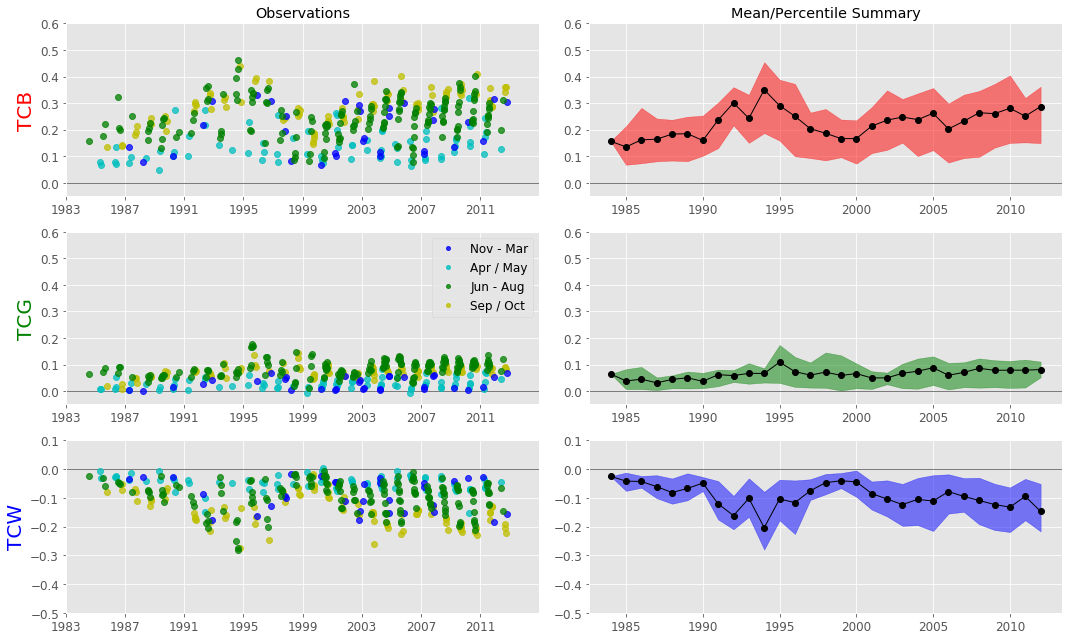

In [37]:
# Time series figure -- 
fig = plt.figure(figsize=(15,9),facecolor='w', edgecolor='k')

#### TCB ####

### Time series
ax = fig.add_subplot(321)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
#plt.axvline(CCDC_date, color='k', ls='-', lw='1.5') # add CCDC date line
months = np.array([d.month for d in dt_dates_fmask])
for season_months, color, alpha in SEASONS.values():
    season_idx = np.in1d(months, season_months)
    plt.plot(dt_dates_fmask[season_idx], Y_fmask[7][season_idx], marker='o',
             mec=color, mfc=color, alpha=alpha, ls='')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylabel('TCB', fontsize=20, color='r')
plt.ylim((-0.0500, 0.6000))
plt.xlim((xmin, xmax))
plt.title('Observations')

### Summary view
ax = fig.add_subplot(322)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line
plt.plot(TCB_mean, lw=1, color='k', ls='-', marker='o')
plt.fill_between(TCB_iqr_H.keys().levels[0], TCB_iqr_H[:].values, TCB_iqr_L[:].values, color='r', alpha=0.5)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylim((-0.0500, 0.6000))
plt.title('Mean/Percentile Summary')

#### TCG

### Time series
ax = fig.add_subplot(323)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
#plt.axvline(CCDC_date, color='k', ls='-', lw='1.5') # add CCDC date line
months = np.array([d.month for d in dt_dates_fmask])
for season_months, color, alpha in SEASONS.values():
    season_idx = np.in1d(months, season_months)
    plt.plot(dt_dates_fmask[season_idx], Y_fmask[8][season_idx], marker='o',
             mec=color, mfc=color, alpha=alpha, ls='')
plt.ylabel('TCG', fontsize=20, color='g')
plt.ylim((-0.0500, 0.6000))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)  
plt.xlim((xmin, xmax))
plt.legend(handles=[winter, spring, summer, fall], fontsize=12)

### Summary view
ax = fig.add_subplot(324)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line
plt.plot(TCG_mean, lw=1, color='k', ls='-', marker='o')
plt.fill_between(TCG_iqr_H.keys().levels[0], TCG_iqr_H[:].values, TCG_iqr_L[:].values, color='g', alpha=0.5)
plt.ylim((-0.0500, 0.6000))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0) 


#### TCW

### Time series
ax = fig.add_subplot(325)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
#plt.axvline(CCDC_date, color='k', ls='-', lw='1.5') # add CCDC date line
months = np.array([d.month for d in dt_dates_fmask])
for season_months, color, alpha in SEASONS.values():
    season_idx = np.in1d(months, season_months)
    plt.plot(dt_dates_fmask[season_idx], Y_fmask[9][season_idx], marker='o',
             mec=color, mfc=color, alpha=alpha, ls='')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylabel('TCW', fontsize=20, color='b')
plt.ylim((-0.5, 0.1000))
plt.xlim((xmin, xmax))

### Summary view
ax = fig.add_subplot(326)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line
plt.plot(TCW_mean, lw=1, color='k', ls='-', marker='o')
plt.fill_between(TCW_iqr_H.keys().levels[0], TCW_iqr_H[:].values, TCW_iqr_L[:].values, color='b', alpha=0.5)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylim((-0.5, 0.1000))

# Save plots
fig.tight_layout()
plt.savefig('./example_data/{y}_{x}_TCpanel_{name}.png'.format(x=px, y=py, name=name))
plt.show()

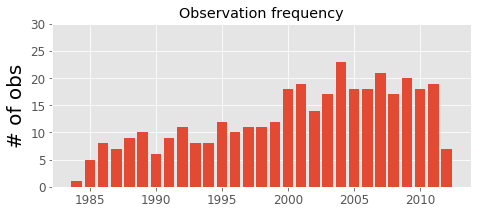

In [46]:
# Number of observations  -- 
fig = plt.figure(figsize=(7.5,3),facecolor='w', edgecolor='k')

plt.bar(TCW_iqr_H.keys().levels[0], nobs.values)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylabel('# of obs', fontsize=20, color='k')
plt.ylim((0, 30))
#plt.xlim((xmin, xmax))
plt.title('Observation frequency')
plt.savefig('./example_data/{y}_{x}_nobs_{name}.png'.format(x=px, y=py, name=name))
plt.show()